# Import libraries

In [2]:
import os
from pandas import read_csv, concat, DataFrame
from datetime import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential

# Load data

In [6]:
# load data
os.chdir('/run/media/sphericalkat/archive/datasets/pollution-timeseries')

dataset = read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0,
                   date_parser=lambda x: datetime.strptime(x, '%Y %m %d %H'))

print(dataset.head())
dataset.drop('No', axis=1, inplace=True)

# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)

# drop the first 24 hours
dataset = dataset[24:]

# save to file
dataset.to_csv('pollution.csv')

dataset.head()

dataset['pollution'].max()

                     No  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
year_month_day_hour                                                   
2010-01-01 00:00:00   1    NaN   -21 -11.0  1021.0   NW   1.79   0   0
2010-01-01 01:00:00   2    NaN   -21 -12.0  1020.0   NW   4.92   0   0
2010-01-01 02:00:00   3    NaN   -21 -11.0  1019.0   NW   6.71   0   0
2010-01-01 03:00:00   4    NaN   -21 -14.0  1019.0   NW   9.84   0   0
2010-01-01 04:00:00   5    NaN   -20 -12.0  1018.0   NW  12.97   0   0


994.0

# Plot data

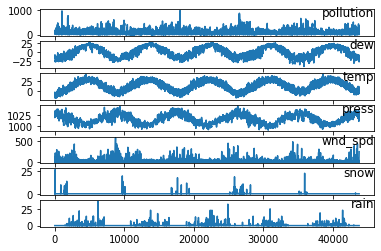

In [4]:
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

# Transform time series data

In [5]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg
 
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data are floats
values = values.astype('float32')

# frame as supervised learning
reframed = series_to_supervised(values, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,129.0,-16.0,-4.0,1020.0,2.0,1.79,0.0,0.0,148.0
2,148.0,-15.0,-4.0,1020.0,2.0,2.68,0.0,0.0,159.0
3,159.0,-11.0,-5.0,1021.0,2.0,3.57,0.0,0.0,181.0
4,181.0,-7.0,-5.0,1022.0,2.0,5.36,1.0,0.0,138.0
5,138.0,-7.0,-5.0,1022.0,2.0,6.25,2.0,0.0,109.0


# Define and fit model

In [6]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24 * 4
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
train_X = scaler1.fit_transform(train_X)
train_y = scaler2.fit_transform(train_y.reshape(-1, 1))

test_X = scaler1.transform(test_X)
test_y = scaler2.transform(test_y.reshape(-1, 1))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(35040, 8) (35040, 1) (8759, 8) (8759, 1)
(35040, 1, 8) (35040, 1) (8759, 1, 8) (8759, 1)


In [7]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        min_delta=1e-2,
        patience=2,
        verbose=1)
]

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(units=1, activation='linear'))

model.compile(loss='mae', optimizer='adam')
model.summary()

# fit network
model.fit(train_X, train_y, epochs=50, batch_size=64, validation_data=(test_X, test_y), 
          verbose=2, shuffle=False, callbacks=callbacks)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11800     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
548/548 - 2s - loss: 0.0344 - val_loss: 0.0317
Epoch 2/50
548/548 - 1s - loss: 0.0169 - val_loss: 0.0161
Epoch 3/50
548/548 - 1s - loss: 0.0156 - val_loss: 0.0133
Epoch 4/50
548/548 - 1s - loss: 0.0152 - val_loss: 0.0135
Epoch 00004: early

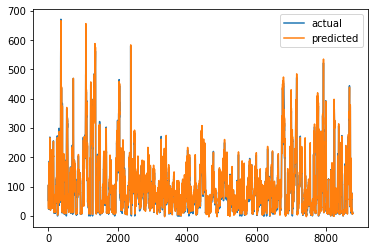

In [8]:
# plot predictions
pyplot.plot(scaler2.inverse_transform(test_y), label = "actual")
pyplot.plot(scaler2.inverse_transform(model.predict(test_X)), label = "predicted")
pyplot.legend()
pyplot.show()



In [9]:
print(test_y.shape)

(8759, 1)
